In [1]:
import numpy as np
from math import sqrt, floor,ceil
import matplotlib.pyplot as plt
import nearest_neighbour as nn
import periodic_BC as BC
import Energy_Conservation as EC
import dLJ
import init_grid as init
import Euler_method as Em
import Leap_Frog as LF
import rescaling
import pair_cor as pc
import pressure as pr
import auto_cor as ac
import time
%matplotlib inline

In [2]:
#Define simulation and global parameters 
#number of particles in the box
n = (3**3)*4 #some conditions: n must be a multiple of 4, and the cuberoot of n/4 must be an integer

#declare time step and total length of the simulation (T in number of timesteps)
h = 0.004
T = 7500

#interval are the timesteps over which the rescaling takes place. rescale_steps are the number of rescalings 
interval = 20
rescale_steps = 125

#define the density of the particles and a desired Temperature
rho = 0.88
Td = 1

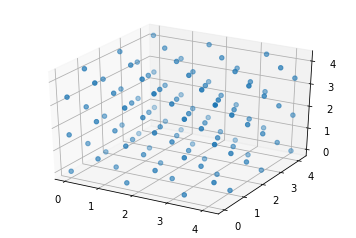

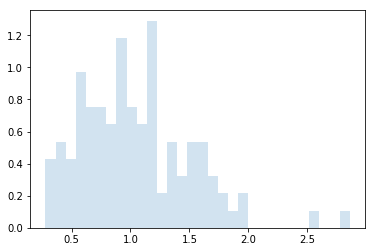

1--- 106.06207060813904 seconds ---


In [3]:
start_time = time.time()
#Simulation 

F_LF = np.zeros([n,3,T])
X_LF = np.zeros([n,3,T])
P_LF = np.zeros([n,3,T])
    
[X_LF[:,:,0],L] = init.init_grid(n,rho)
P_LF[:,:,0] = init.init_velocity(X_LF[:,:,0],Td)

time_after = interval*rescale_steps

[X_LF,P_LF,T_check] = rescaling.rescaling(h,L,X_LF,P_LF,Td,interval,rescale_steps)
[X_LF[:,:,time_after:T],P_LF[:,:,time_after:T]] = LF.Leap_Frog(h,L,X_LF[:,:,time_after:T],P_LF[:,:,time_after:T])
print("1--- %s seconds ---" %(time.time() - start_time))

In [5]:
start_time = time.time()
# CHECK: Energy conservation and equilibrium
[KV, K, V] = EC.En_Cons(X_LF,P_LF,L)
# Plots
plt.figure()
plt.plot(KV/n)
plt.plot(K/n)
plt.plot(V/n)
plt.title('Internal, kinetic and potential energy vs timesteps')
plt.gca().legend(('Internal','Kinetic','Potential'),loc = 1)
print("1--- %s seconds ---" %(time.time() - start_time))


1--- 62.188117265701294 seconds ---


1--- 103.72669076919556 seconds ---


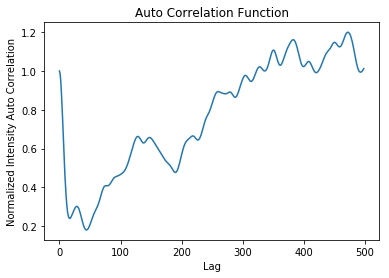

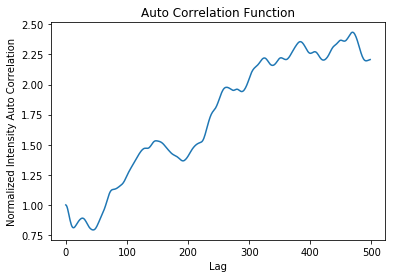

In [6]:
start_time = time.time()
# Plot autocorrelation of the energy
chi_K = ac.auto_cor(K[time_after:-1])
chi_V = ac.auto_cor(V[time_after:-1])
print("1--- %s seconds ---" %(time.time() - start_time))

Kinetic Energy = 163.034795964 ( 162.5505589 , 163.519033029 )
Potential Energy = -645.8199551 ( -647.985715657 , -643.654194544 )
Internal Energy per particle = -4.47023295496 ( -4.49476996997 , -4.44569593995 )
1--- 0.05851173400878906 seconds ---


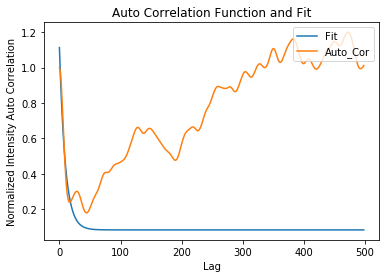

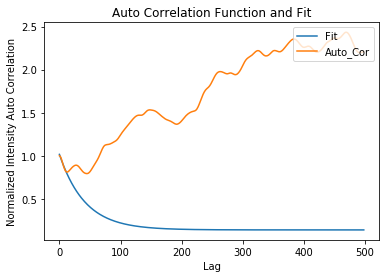

In [18]:
start_time = time.time()
# Fit autocorrelation to obtain correlation time. 
#----------------!INPUT FITTING PARAMETERS!-----------------------------------
r_bound_K = 23 #GIVE RIGHT BOUND FOR VALUES INCLUDED IN THE FITTING PROCEDURE
r_bound_V = 13 #GIVE RIGHT BOUND FOR VALUES INCLUDED IN THE FITTING PROCEDURE
#-----------------------------------------------------------------------------
tau_K = ac.fit_auto_cor(chi_K,r_bound_K)
tau_V = ac.fit_auto_cor(chi_V,r_bound_V)
    
[mean_K, std_K]= ac.mean_std(K,tau_K,'Kinetic Energy')
[mean_V, std_V]= ac.mean_std(V,tau_V,'Potential Energy')

print('Internal Energy per particle =',(mean_K+mean_V)/n,'(',(mean_K+mean_V-std_K-std_V)/n,',',(mean_K+mean_V+std_K+std_V)/n,')')
print("1--- %s seconds ---" %(time.time() - start_time))    


1--- 53.565988063812256 seconds ---


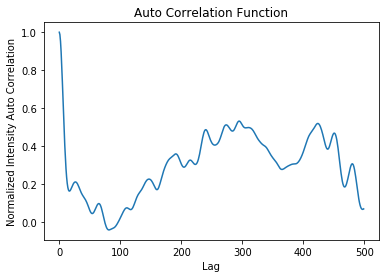

In [14]:
start_time = time.time()
# CHECK: Temperature vs Time after rescaling incl. auto correlation, average T and uncertainties.
T_check = np.array([np.sum(P_LF[:,:,time_after+i]**2)/(3*(n-1)) for i in range(T-time_after)])
chi_T_check = ac.auto_cor(T_check)
print("1--- %s seconds ---" %(time.time() - start_time))    

T = 1.00906862535 ( 1.00602866392 , 1.01210858678 )
1--- 0.03001093864440918 seconds ---


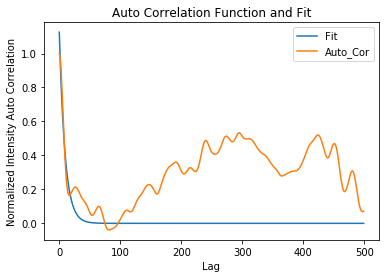

In [17]:
start_time = time.time()
# Fit autocorrelation to obtain correlation time. 
#----------------!INPUT FITTING PARAMETERS!-----------------------------------
r_bound_T = 23 #GIVE RIGHT BOUND FOR VALUES INCLUDED IN THE FITTING PROCEDURE
#-----------------------------------------------------------------------------
tau_T = ac.fit_auto_cor(chi_T_check,r_bound_T)
[mean_T, std_T]= ac.mean_std(T_check,tau_T,'T')
print("1--- %s seconds ---" %(time.time() - start_time)) 

In [1]:
# CHECK: Reversibility 

1--- 95.24949789047241 seconds ---


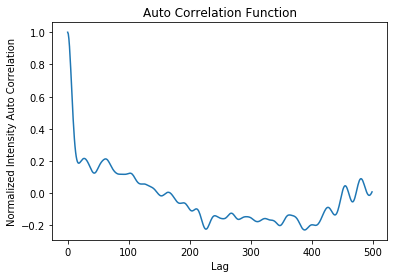

In [18]:
#Pressure
start_time = time.time()
[virial] = pr.virial(X_LF,L,Td,time_after) 
chi_virial = ac.auto_cor(virial)
print("1--- %s seconds ---" %(time.time() - start_time)) 

Virial = -1904.45127795 ( -1922.3681892 , -1886.5343667 )
Pressure = 6.80056485535
Pressure = 6.85586396413
Pressure = 6.74526574656
1--- 0.021687030792236328 seconds ---


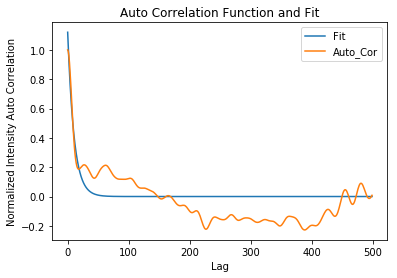

In [25]:
# Fit autocorrelation to obtain correlation time. 
start_time = time.time()
#----------------!INPUT FITTING PARAMETERS!-----------------------------------
r_bound_virial = 24 #GIVE RIGHT BOUND FOR VALUES INCLUDED IN THE FITTING PROCEDURE
#-----------------------------------------------------------------------------
tau_virial = ac.fit_auto_cor(chi_virial,r_bound_virial)
[mean_virial, std_virial]= ac.mean_std(virial,tau_virial,'Virial')

mean_pressure = pr.pressure(n,Td,L,mean_virial,rho)
max_pressure = pr.pressure(n,Td,L,mean_virial-std_virial,rho)
min_pressure = pr.pressure(n,Td,L,mean_virial+std_virial,rho)
print("1--- %s seconds ---" %(time.time() - start_time)) 

amount boxes =  27
1--- 267.75696301460266 seconds ---


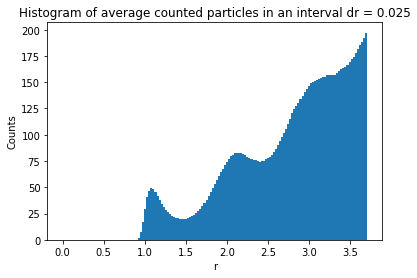

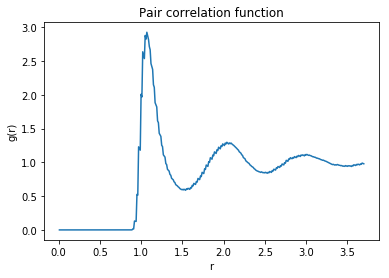

In [26]:
#Pair Correlation function:
start_time = time.time()
dR = L/200
A=pc.pair_cor(X_LF,L,rescale_steps,interval,dR)
print("1--- %s seconds ---" %(time.time() - start_time)) 

In [ ]:
# Euler Method
#declare initial conditions for the Euler Method
F = np.zeros([n,3,T]) #Force array
X = np.zeros([n,3,T])
V = np.zeros([n,3,T])
[X[:,:,0],L] = init.init_grid(n,rho)
V[:,:,0] = init.init_velocity(X[:,:,0],Td)

resc = 5 #The number of times the velocity will be rescaled
Td = 1 # The desired temperature
dT = 10 #number of timesteps after which the temperature is rescaled
for k in range(resc):
    k0 = k*dT
    k1 = (k+1)*dT+1
    [X[:,:,k0:k1],V[:,:,k0:k1],F[:,:,k0:k1]] = Em.Euler(h,dT+1,L,n,X[:,:,k0:k1],V[:,:,k0:k1],F[:,:,k0:k1])
    #print(X[:,:,10*(k+1)])
    #print(V[:,:,10*(k+1)])
    Lambda = np.sqrt(((n-1)*3*Td)/(np.sum(V[:,:,k1-1]**2)))
    print(Lambda)
    V[:,:,k1-1] = Lambda * V[:,:,k1-1]
    
[X[:,:,resc*dT:T],V[:,:,resc*dT:T],F[:,:,resc*dT:T]]=Em.Euler(h,T-resc*dT,L,n,X[:,:,resc*dT:T],V[:,:,resc*dT:T],F[:,:,resc*dT:T])

E = EC.En_Cons(X,V,L)
plt.figure().add_subplot(111).plot(E[0][0:160])

import holoviews as hv
import numpy as np
hv.notebook_extension()

timestep = np.arange(0,T-1)
dimensions = ['times']
key = [(t) for t in timestep]
items = [(k, hv.Scatter3D(X[:,:,k])) for k in key]
locations = hv.HoloMap(items, kdims =dimensions)
locations